In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

#### California Housing Prices

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv')

<AxesSubplot:>

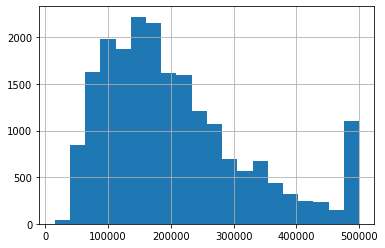

In [5]:
df.median_house_value.hist(bins=20)

In [6]:
df =  df[['latitude','longitude','housing_median_age','total_rooms','total_bedrooms','population',\
'households','median_income','median_house_value']]

#### Question 1
Find a feature with missing values. How many missing values does it have?

In [7]:
df.isna().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

#### Question 2
What's the median (50% percentile) for variable 'population'?

In [30]:
df.population.median()

1166.0

#### Split the data
* Shuffle the initial dataset, use seed 42.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Make sure that the target value ('median_house_value') is not in your dataframe.
* Apply the log transformation to the median_house_value variable using the np.log1p() function.

In [9]:
def prepare_data(df,seed):
    np.random.seed(seed)

    n = len(df)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    
    X_train = df_train.drop(columns = 'median_house_value').values
    y_train = np.log1p(df_train[['median_house_value']]).values
    X_val = df_val.drop(columns = 'median_house_value').values
    y_val = np.log1p(df_val[['median_house_value']]).values
    X_test= df_test.drop(columns = 'median_house_value').values
    y_test = np.log1p(df_test[['median_house_value']]).values
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

#### Question 3
* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using round(score, 2)
Which option gives better RMSE?


* With 0

In [11]:
df1 = df.copy()
df1.total_bedrooms.fillna(0,inplace=True)

In [12]:
 X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(df1,42)

In [13]:
w_0, w = train_linear_regression(X_train, y_train)

In [14]:
y_pred = w_0 + X_train.dot(w)
print('train', rmse(y_train, y_pred))

y_pred = w_0 + X_val.dot(w)
print('validation', rmse(y_val, y_pred))

train 0.34131359101566755
validation 0.3295330365224293


* With mean

In [15]:
df2 = df.copy()
df2.total_bedrooms.fillna(df.total_bedrooms.mean(),inplace=True)

In [16]:
 X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(df2,42)

In [17]:
w_0, w = train_linear_regression(X_train, y_train)

In [18]:
y_pred = w_0 + X_train.dot(w)
print('train', rmse(y_train, y_pred))

y_pred = w_0 + X_val.dot(w)
print('validation', rmse(y_val, y_pred))

train 0.34104146565797155
validation 0.3290193910380207


* With median

In [19]:
df3 = df.copy()
df3.total_bedrooms.fillna(df.total_bedrooms.median(),inplace=True)

In [20]:
 X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(df3,42)

In [21]:
w_0, w = train_linear_regression(X_train, y_train)

In [22]:
y_pred = w_0 + X_train.dot(w)
print('train', rmse(y_train, y_pred))

y_pred = w_0 + X_val.dot(w)
print('validation', rmse(y_val, y_pred))

train 0.3410596192663746
validation 0.3290480473466386


#### Question 4
* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0.
* Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which r gives the best RMSE?
* If there are multiple options, select the smallest r

In [23]:
 X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(df1,42)

In [24]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [25]:
rmse_list = []
alphas = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
for r in alphas :
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    rmse_list.append(rmse(y_val, y_pred))
    
best_alpha = alphas[rmse_list.index(min(rmse_list))]
best_alpha

0.01

#### Question 5
* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
* What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
* Round the result to 3 decimal digits (round(std, 3))

In [26]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_list = []
for seed in seeds:
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(df1,seed)
    w_0, w = train_linear_regression(X_train, y_train)
    y_pred = w_0 + X_val.dot(w)
    rmse_list.append(rmse(y_val, y_pred))
best_seed = seeds[rmse_list.index(min(rmse_list))]
print('Std',round(np.std(rmse_list),3),'| best_seed:',best_seed)

Std 0.004 | best_seed: 2


#### Question 6
* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with r=0.001.
* What's the RMSE on the test dataset?

In [27]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(df1,9)

In [28]:
X = np.concatenate((X_train,X_val),axis=0)
y = np.concatenate((y_train,y_val),axis=0)
w_0, w = train_linear_regression_reg(X, y, r=0.001)
y_pred = w_0 + X.dot(w)
round(rmse(y, y_pred),3)

0.34